In [1064]:
########################################
# STEP 0: import libraries
########################################
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import sklearn.tree
import sklearn.ensemble
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
import nltk
import pandas as pd
import sklearn.datasets
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.random_projection
import sklearn.tree
import sklearn.svm
nltk.download('vader_lexicon') # Should print 3.9.1 or another recent version




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/avagrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [1065]:
###reading in initial###
df = pd.read_csv(("~/Downloads/train_data.csv"))
df.head(1)

,X,fullText,day,Harris,Trump,July,August,September,October,November,likes,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,0.000025,0.00001,0.000023,0.000019,0.020858,1,trump,indirect,negative


In [1066]:
########################################
# SUB-STEP: Prepare the dataset
########################################
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    return analyzer.polarity_scores(text)['compound']

df['vader_score'] = df['fullText'].apply(get_vader_score)


def sentiment_match(vader_score, label):
    if vader_score > 0.05:
        vader_label = "positive"
    elif vader_score < -0.05:
        vader_label = "negative"
    else:
        vader_label = "neutral"  # Ensure consistency with manual labels

    return vader_label == label

df['vader_match'] = df.apply(lambda row: sentiment_match(row['vader_score'], row['Sentiment']), axis=1)

match_rate = df['vader_match'].mean()
print(f"VADER matches manual labels {match_rate*100:.2f}% of the time.")


df['Candidate'] = df['Candidate'].str.strip().str.lower()  # Remove spaces & lowercase
candidate_mapping = {'trump': 1, 'harris': 2, 'neither': 3}
df['Candidate'] = df['Candidate'].map(candidate_mapping)
df['Candidate'] = df['Candidate'].fillna(1).astype(int)
df.head(5)

VADER matches manual labels 45.80% of the time.


,X,fullText,day,Harris,Trump,July,August,September,October,November,...,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment,vader_score,vader_match
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,...,0.000010,0.000023,0.000019,0.020858,1,1,indirect,negative,-0.4404,True
1,21769,i can’t believe trump is really launching a pr...,13,0,1,0,0,0,1,0,...,0.000052,0.000139,0.000889,0.035637,2,3,neutral,neutral,0.0000,True
2,20243,trump on the radio show sid & friends in the m...,7,0,1,0,0,0,1,0,...,0.000062,0.000054,0.000057,0.011930,3,1,indirect,negative,0.9423,False
3,16181,most of these trump supporting men are lonely ...,21,0,1,0,0,1,0,0,...,0.000010,0.000003,0.000019,0.117333,4,1,indirect,negative,-0.7003,True
4,4854,i think weve all confused jerry brown with wil...,9,0,1,0,1,0,0,0,...,0.000146,0.000071,0.000227,0.053209,5,3,neutral,neutral,0.0516,False


In [1067]:
print(df[["fullText", "Candidate", "vader_score"]].head(50))

# Step 1: Create a binary column for class 3
df_model['is_class_3'] = (df_model['Candidate'] == 3).astype(int)

# Step 2: Compute correlation of all numeric columns with is_class_3
correlations = df_model.corr(numeric_only=True)['is_class_3'].sort_values(ascending=False)

# Step 3: Show results
print("🔼 Features positively correlated with class 3:")
print(correlations.head(15))

print("\n🔽 Features negatively correlated with class 3:")
print(correlations.tail(15))



                                             fullText  Candidate  vader_score
0   i think what people aren’t taking about enough...          1      -0.4404
1   i can’t believe trump is really launching a pr...          3       0.0000
2   trump on the radio show sid & friends in the m...          1       0.9423
3   most of these trump supporting men are lonely ...          1      -0.7003
4   i think weve all confused jerry brown with wil...          3       0.0516
5   🚀 my personal bull market forecasts for projec...          3       0.4588
6   if you believe kamalas policies will bring dow...          2       0.2023
7   cnn is reporting that officials believe that t...          3      -0.5423
8   i know its early and its foolish for me to say...          2       0.9460
9   i believe it’s time to start making purchases ...          3       0.3612
10  mainstream media and professional centrists an...          1      -0.1260
11  good afternoon all! call me weird because i be...          1

In [1068]:
########################################
# STEP 1: Process the dataset
########################################

df_model = df.drop(columns = ['vader_match', 'X', 'Harris', 'Trump'])

print(f"df_model.shape={df_model.shape}")

df_model.shape=(500, 17)


In [1069]:
########################################
# STEP 2: Apply "non-learned" data transformations
########################################
vectorizer = TfidfVectorizer(max_features=475)
X_model_tfidf = vectorizer.fit_transform(df_model['fullText'])

# Step 3: Convert to DataFrame
tfidf_train_df = pd.DataFrame(X_model_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Step 4: Remove 'fullText' and 'sentiment' before merging
df_model_features = df_model.drop(columns=['fullText', 'Candidate', 'Sentiment', 'direction', 'id'])

# Step 5: Ensure alignment by resetting index
x_train = pd.concat([tfidf_train_df.reset_index(drop=True), df_model_features.reset_index(drop=True)], axis=1)

# Step 6: Define Target Variable
y_train = df_model['Candidate'].reset_index(drop=True)

# Step 7: Verify Final Data
print("Final x_train shape:", x_train.shape)  # Should match (90, 1018) if 18 + 1000 features
print("Final y_train shape:", y_train.shape)
print(x_train.head())  # or print(df_train.head()) to check your dataset
print(y_train.head())

Final x_train shape: (500, 487)
Final y_train shape: (500,)
    10      2016  2020  2024  2025  abortion     about  absolutely  actually  \
0  0.0  0.280883   0.0   0.0   0.0       0.0  0.143627         0.0       0.0   
1  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   
2  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   
3  0.0  0.000000   0.0   0.0   0.0       0.0  0.157115         0.0       0.0   
4  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   

   administration  ...  August  September  October  November     likes  \
0             0.0  ...       1          0        0         0  0.000025   
1             0.0  ...       0          0        1         0  0.000208   
2             0.0  ...       0          0        1         0  0.000024   
3             0.0  ...       0          1        0         0  0.000021   
4             0.0  ...       1          0        0         0  0.000178   

   retweets   

In [1070]:
########################################
# STEP 3: Create train/test sets
########################################
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train  # Maintains class balance
)

# Further split training into train/validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=42, stratify=Y_train
)

# Print new distributions
print("New Training Class Distribution:\n", Y_train.value_counts(normalize=True))
print("\nNew Validation Class Distribution:\n", Y_val.value_counts(normalize=True))
print("\nNew Test Class Distribution:\n", Y_test.value_counts(normalize=True))

# Print final shapes
print(f"Training set: X_train={X_train.shape}, Y_train={Y_train.shape}")
print(f"Validation set: X_val={X_val.shape}, Y_val={Y_val.shape}")
print(f"Test set: X_test={X_test.shape}, Y_test={Y_test.shape}")


New Training Class Distribution:
 Candidate
1    0.438235
2    0.388235
3    0.173529
Name: proportion, dtype: float64

New Validation Class Distribution:
 Candidate
1    0.433333
2    0.400000
3    0.166667
Name: proportion, dtype: float64

New Test Class Distribution:
 Candidate
1    0.44
2    0.39
3    0.17
Name: proportion, dtype: float64
Training set: X_train=(340, 487), Y_train=(340,)
Validation set: X_val=(60, 487), Y_val=(60,)
Test set: X_test=(100, 487), Y_test=(100,)


In [1071]:
########################################
# STEP 4: Apply "learned" data transformations
########################################

pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(X_train)  # Fit only on training data

# Transform all datasets using the learned PCA transformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# Print the new shapes
print(f"X_train_pca.shape = {X_train_pca.shape}")
print(f"X_test_pca.shape = {X_test_pca.shape}")
print(f"X_val_pca.shape = {X_val_pca.shape}")

X_train_pca.shape = (340, 50)
X_test_pca.shape = (100, 50)
X_val_pca.shape = (60, 50)


In [1072]:
########################################
# STEP 5: Train a model
########################################

#model_base = sklearn.tree.DecisionTreeClassifier(
   # criterion='entropy',
    #max_depth=2,
    #min_samples_split=5,
   # min_samples_leaf=30,
    #max_features=None,
    #max_leaf_nodes=25,
    #random_state=42,
   # )
#model = sklearn.ensemble.AdaBoostClassifier(
   # estimator=model_base,
   # n_estimators=40,
   # ) = 75 and 82

model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=5,
    min_samples_split=10,
    random_state=4,  
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced'  
)


model.fit(X_train, Y_train)

# most of our discussions in class about "error"
# accuracy is just 1 - error

# Report accuracy scores
validation_accuracy = model.score(X_val, Y_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

train_accuracy = model.score(X_train, Y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Generate classification report for validation set
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
print("\nTrain Set Metrics:")
print(classification_report(Y_train, y_train_pred))

y_val_pred = model.predict(X_val)
print("\nValidation Set Metrics:")
print(classification_report(Y_val, y_val_pred))




Validation Accuracy: 0.7167
Train Accuracy: 0.8853

Train Set Metrics:
              precision    recall  f1-score   support

           1       0.87      0.97      0.92       149
           2       0.88      0.93      0.90       132
           3       0.97      0.58      0.72        59

    accuracy                           0.89       340
   macro avg       0.91      0.82      0.85       340
weighted avg       0.89      0.89      0.88       340


Validation Set Metrics:
              precision    recall  f1-score   support

           1       0.68      0.88      0.77        26
           2       0.86      0.79      0.83        24
           3       0.25      0.10      0.14        10

    accuracy                           0.72        60
   macro avg       0.60      0.59      0.58        60
weighted avg       0.68      0.72      0.69        60



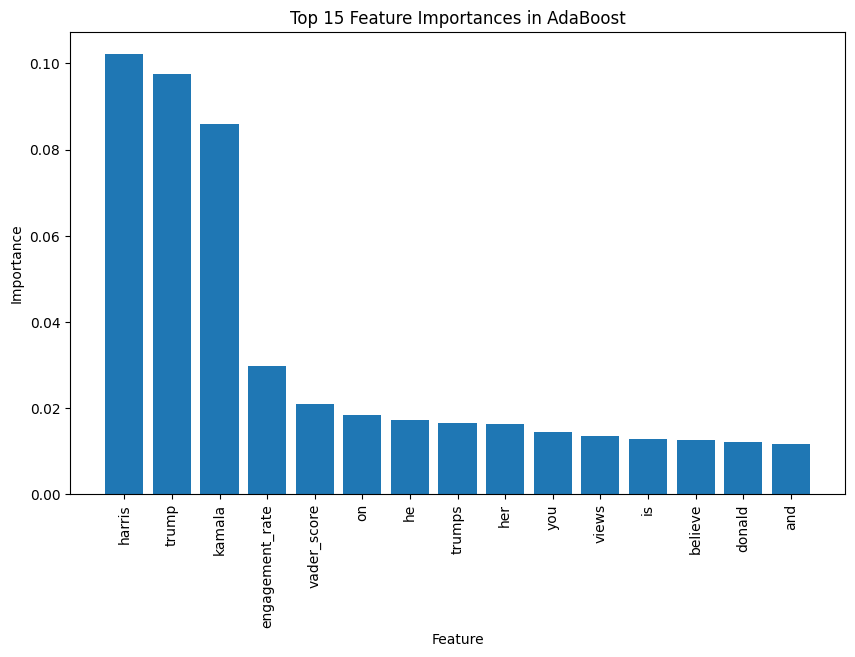

In [1073]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance from AdaBoost model
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Get feature names

# Sort features by importance (descending order)
indices = np.argsort(feature_importances)[::-1]

# Select top 15 features
top_n = 15
top_indices = indices[:top_n]
top_features = np.array(feature_names)[top_indices]
top_importances = feature_importances[top_indices]

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances in AdaBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

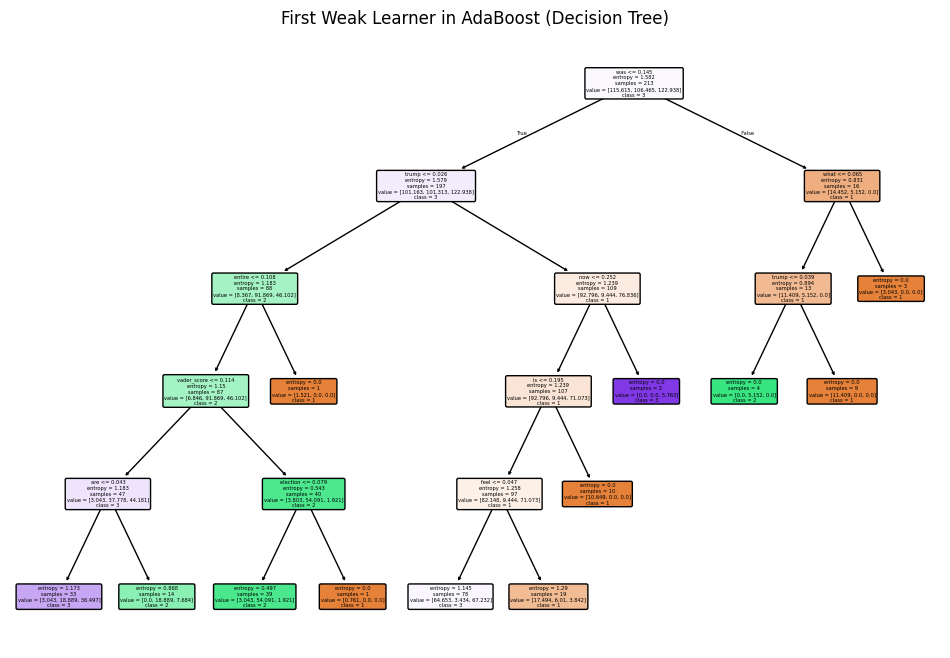

In [1074]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get first weak learner (decision tree)
first_tree = model.estimators_[0]

# Dynamically extract class names from Y_train
class_labels = [str(label) for label in np.unique(Y_train)]

# Ensure it's a Decision Tree before plotting
if hasattr(first_tree, "tree_"):
    plt.figure(figsize=(12, 8))
    plot_tree(
        first_tree, 
        feature_names=X_train.columns, 
        class_names=class_labels,  # Use dynamically extracted class names
        filled=True, rounded=True
    )
    plt.title("First Weak Learner in AdaBoost (Decision Tree)")
    plt.show()
else:
    print("First weak learner is not a decision tree. Check AdaBoost configuration.")



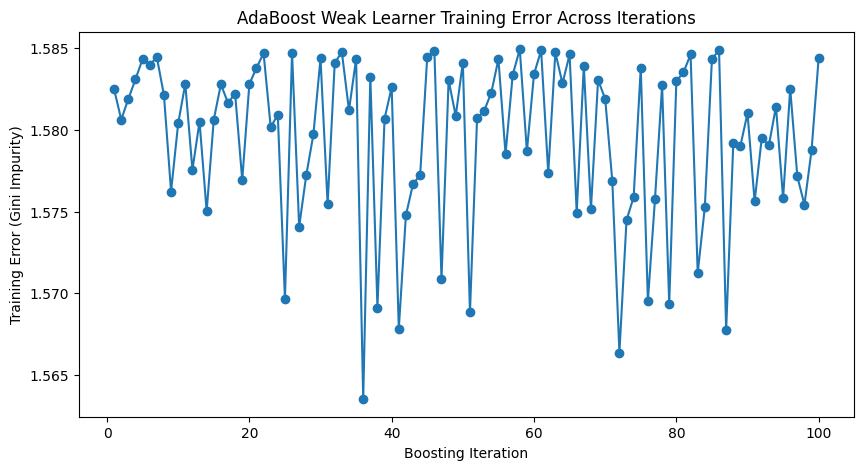

In [1075]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the training errors from each weak learner
errors = np.array([estimator.tree_.impurity[0] for estimator in model.estimators_])

# Plot training error across boosting iterations
plt.figure(figsize=(10,5))
plt.plot(range(1, len(errors)+1), errors, marker='o', linestyle='-')
plt.xlabel("Boosting Iteration")
plt.ylabel("Training Error (Gini Impurity)")
plt.title("AdaBoost Weak Learner Training Error Across Iterations")
plt.show()



In [1076]:
# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 3 to others
candidate_3_diff = feature_means_by_candidate.loc[3] - feature_means_by_candidate.loc[[1, 2]].mean()

# Show top differences
print(candidate_3_diff.sort_values(ascending=False).head(20))

day              0.135411
August           0.032582
on               0.028076
July             0.025607
November         0.023570
trump            0.023302
as               0.019349
do               0.017687
assassination    0.017547
yall             0.017111
crazy            0.016608
president        0.016247
million          0.015695
with             0.014558
after            0.013616
about            0.013578
believe          0.013521
chris            0.013303
victory          0.013084
should           0.012974
dtype: float64


In [1077]:
import pandas as pd

# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 2 to Candidate 1
candidate_2_vs_1 = feature_means_by_candidate.loc[2] - feature_means_by_candidate.loc[1]
candidate_2_vs_1_sorted = candidate_2_vs_1.sort_values(ascending=False)

# Compare Candidate 1 to Candidate 2
candidate_1_vs_2 = feature_means_by_candidate.loc[1] - feature_means_by_candidate.loc[2]
candidate_1_vs_2_sorted = candidate_1_vs_2.sort_values(ascending=False)

# Convert to DataFrames for better readability
candidate_2_vs_1_df = candidate_2_vs_1_sorted.to_frame()
candidate_2_vs_1_df.columns = ["Difference (Candidate 2 - Candidate 1)"]

candidate_1_vs_2_df = candidate_1_vs_2_sorted.to_frame()
candidate_1_vs_2_df.columns = ["Difference (Candidate 1 - Candidate 2)"]

# Display the top 20 distinctive features for each comparison
print("🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:")
print(candidate_2_vs_1_df.head(20))

print("\n🔹 Features that appear more in Candidate 1's tweets than Candidate 2's:")
print(candidate_1_vs_2_df.head(20))

#overall trend (similar to direction) harris has more indirect related tweets while trump is more direct 
# for exmaple, harris as a lot of identifiers with biden, or walz while trump has win, election, etc

🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:
             Difference (Candidate 2 - Candidate 1)
day                                        1.268253
vader_score                                0.145468
kamala                                     0.090833
harris                                     0.077660
July                                       0.044794
she                                        0.039826
her                                        0.038168
October                                    0.022015
biden                                      0.019635
be                                         0.017975
for                                        0.017889
but                                        0.017048
September                                  0.016829
anyone                                     0.014517
does                                       0.013889
from                                       0.013764
than                                       0

In [1078]:
########################################
# STEP 6: Evaluate on test set
########################################

# WARNING:
# this code should be run only once;
# after the hyperparameters have been decided based on the validation performance,
# then the False can be changed to True to run this code
if True:
    model.fit(X_train, Y_train)
    test_accuracy = model.score(X_test, Y_test)
    print(f"test_accuracy={test_accuracy}")

    y_test_pred = model.predict(X_test)

    # Compute test set metrics
    print("Test Set Metrics:")
    print(classification_report(Y_test, y_test_pred))

test_accuracy=0.81
Test Set Metrics:
              precision    recall  f1-score   support

           1       0.78      0.95      0.86        44
           2       0.84      0.97      0.90        39
           3       1.00      0.06      0.11        17

    accuracy                           0.81       100
   macro avg       0.87      0.66      0.62       100
weighted avg       0.84      0.81      0.75       100



In [1079]:
y_all_pred = model.predict(x_train)

df_model2 = df_model.reset_index(drop=True)  # Ensure alignment
df_model2['candidate_pred'] = y_all_pred

df_model2.shape[0]
df_model2 = df_model2[["fullText", "Candidate", "candidate_pred"]]

accuracy = (df_model2['Candidate'] == df_model2['candidate_pred']).mean()
print(f"Overall accuracy on full 500 samples: {accuracy:.4f}")

df_mistakes = df_model2[df_model['Candidate'] != df_model2['candidate_pred']]
print(df_mistakes[['fullText', 'Candidate', 'candidate_pred']].head(10))





Overall accuracy on full 500 samples: 0.8500
                                             fullText  Candidate  \
1   i can’t believe trump is really launching a pr...          3   
15  i believe when trump is finally gone i will ex...          1   
23   um julie i think god knows how to pronounce k...          2   
29  how do yall feel about trumps proposal to abol...          3   
32  so republicans are mad bc they (falsely) belie...          3   
35  let me get this straight: democrats lied to th...          3   
37  for people who dont see muslims & arabs as hum...          3   
44  us political class wants us to believe ✌️unity...          3   
48       do you believe kamala harris is a gun owner?          3   
52   he is from my state and i dont believe that h...          2   

    candidate_pred  
1                1  
15               3  
23               1  
29               1  
32               2  
35               2  
37               2  
44               1  
48               